시작하기전 구글 드라이브의 MyDrive에 dataset이름의 새폴더를 만들고 이 폴더로 다운로드받은 zip파일을 업로드해야함

In [63]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

In [64]:
# 구글 드라이브 폴더 마운트 (코랩을 사용하는 경우)
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
# 압축 파일의 위치 (구글 드라이브 - 내 드라이브 위치)
drive_path = "/content/drive/MyDrive/"
source_filename = drive_path + "dataset/Interior_Dataset.zip"

# 저장할 경로
extract_folder = "dataset/" # 코랩 환경에 임시 저장

# 압축 해제
import shutil
shutil.unpack_archive(source_filename, extract_folder)

In [66]:
# 훈련 셋, 검증 셋 저장 위치 지정
train_dir = extract_folder + "training_set"
valid_dir = extract_folder + "test_set"
print(train_dir)
print(valid_dir)


dataset/training_set
dataset/test_set


In [67]:
# 이미지 데이터 제너레이터 정의 (Augmentation 미적용)
image_gen = ImageDataGenerator(rescale = (1/255.0))
image_gen

In [68]:
# flow_from_directory 함수로 폴더에서 이미지를 가져와 제너레이터 객체로 정리
train_gen = image_gen.flow_from_directory(train_dir, batch_size = 10, target_size = (224,224), classes = ['Casual Style','Classic Style','Modern Style','Natural Style'],
                                          class_mode = 'sparse')

valid_gen = image_gen.flow_from_directory(valid_dir, batch_size = 10, target_size = (224,224), classes = ['Casual Style','Classic Style','Modern Style','Natural Style'],
                                          class_mode = 'sparse')

Found 480 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


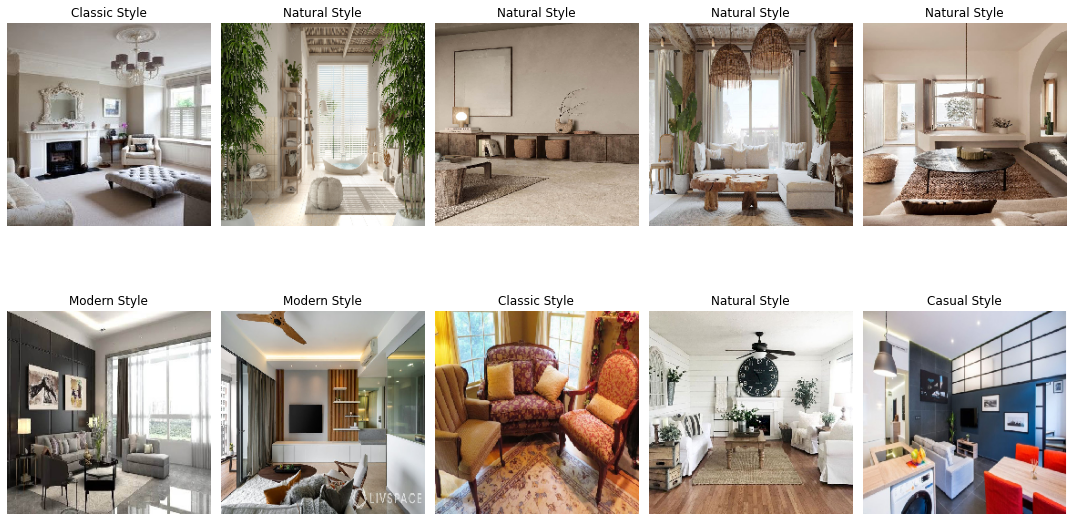

In [70]:
# 샘플 이미지 출력
class_labels = ['Casual Style','Classic Style','Modern Style','Natural Style']
batch = next(train_gen)

images, labels = batch[0], batch[1]

plt.figure(figsize = (15,9))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(images[i])
  plt.title(class_labels[labels[i].astype(np.int)])
  plt.axis('off')

plt.tight_layout()  
plt.show()

In [71]:
# Sequential API를 사용하여 샘플 모델 형성

def build_model():

  model = tf.keras.Sequential([
                               
      # Convolution 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32,(3,3), padding = 'same', activation = 'relu', input_shape = (224,224,3)),
      tf.keras.layers.MaxPooling2D((2,2)),
      
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(4, activation = 'softmax')
      ])
  
  return model

model = build_model()

In [72]:
from gc import callbacks
# 모델 컴파일
model.compile(optimizer = 'adam',
              loss ='sparse_categorical_crossentropy',
              metrics = 'accuracy')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best-cnn-interior-model.h5', 
                                                   save_best_only = True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 7, 
                                                     restore_best_weights= True)

# 모델 훈련
history = model.fit(train_gen, validation_data = valid_gen, epochs = 40,
                    callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/40
48/48 [==============================] - 14s 265ms/step - loss: 22.9033 - accuracy: 0.3417 - val_loss: 1.9795 - val_accuracy: 0.3667
Epoch 2/40
48/48 [==============================] - 12s 259ms/step - loss: 1.5850 - accuracy: 0.5500 - val_loss: 1.2989 - val_accuracy: 0.3583
Epoch 3/40
48/48 [==============================] - 12s 245ms/step - loss: 0.9493 - accuracy: 0.6167 - val_loss: 1.5341 - val_accuracy: 0.2500
Epoch 4/40
48/48 [==============================] - 12s 256ms/step - loss: 0.8087 - accuracy: 0.6583 - val_loss: 1.1568 - val_accuracy: 0.4583
Epoch 5/40
48/48 [==============================] - 12s 245ms/step - loss: 0.6819 - accuracy: 0.7396 - val_loss: 1.2675 - val_accuracy: 0.4667
Epoch 6/40
48/48 [==============================] - 13s 265ms/step - loss: 0.6128 - accuracy: 0.7667 - val_loss: 0.7847 - val_accuracy: 0.7167
Epoch 7/40
48/48 [==============================] - 12s 255ms/step - loss: 0.4252 - accuracy: 0.8396 - val_loss: 0.8665 - val_accuracy: 0.683

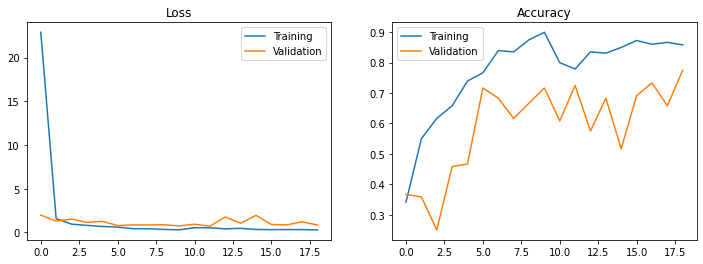

In [73]:
# 손실함수, 정확도 그래프 그리기
def plot_loss_acc(history):
  fig, axes =  plt.subplots(1,2, figsize = (12,4))
  axes[0].plot( history.history['loss'])
  axes[0].plot(history.history['val_loss'])
  axes[0].legend(labels = ['Training', 'Validation'])
  axes[0].set_title('Loss')
  
  axes[1].plot(history.history['accuracy'])
  axes[1].plot(history.history['val_accuracy'])
  axes[1].legend(labels = ['Training', 'Validation'])
  axes[1].set_title('Accuracy')

plot_loss_acc(history)

In [74]:
model.evaluate(valid_gen)

12/12 [==============================] - 2s 193ms/step - loss: 0.7077 - accuracy: 0.7250


[0.707658052444458, 0.7250000238418579]

In [75]:
# 예측

class_labels = ['Casual Style','Classic Style','Modern Style','Natural Style']

batch = next(valid_gen)
print(batch[1])
images, labels = batch[0], batch[1]
print(labels)

predictions = model.predict(batch[0])

[0. 1. 0. 1. 1. 1. 3. 0. 0. 3.]
[0. 1. 0. 1. 1. 1. 3. 0. 0. 3.]


In [76]:
predictions.shape
print(predictions[0])

[0.5164505  0.16844814 0.01504553 0.30005577]


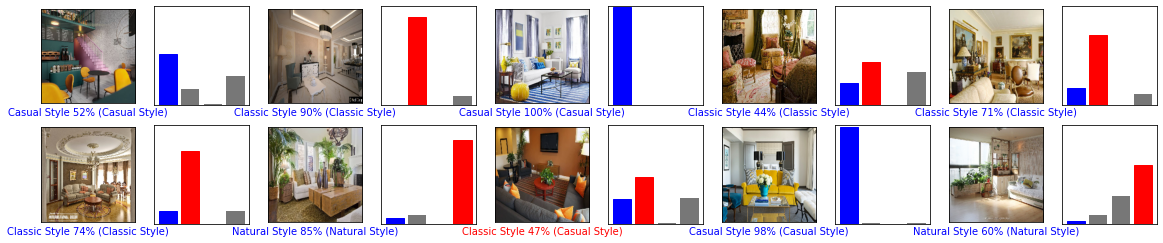

In [77]:
def plot_image(i, predictions_array, true_label, img): #순서, 예측확률
  predictions_array, img = predictions_array[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
 
  plt.imshow(img, cmap=plt.cm.binary)
 
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
 
  plt.xlabel("{} {:2.0f}% ({})".format(class_labels[predicted_label],
                                100*np.max(predictions_array),
                                class_labels[int(true_label)]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[np.argmax(true_label)].set_color('blue')

  
num_rows = 2
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))


for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, labels[i], images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions,labels)
plt.show()

In [ ]:
# 이미지 데이터 제너레이터 정의 (Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale = 1/255.0,
                                   horizontal_flip = True,
                                   rotation_range = 30
                                    )

# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리
train_gen_aug = image_gen_aug.flow_from_directory(train_dir,
                                                  batch_size = 10,
                                                  target_size = (224,224),
                                                  classes = ['Casual Style','Classic Style','Modern Style','Natural Style'],
                                                  class_mode = 'sparse',
                                                  )

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir,
                                                  batch_size = 10,
                                                  target_size = (224,224),
                                                  classes = ['Casual Style','Classic Style','Modern Style','Natural Style'],
                                                  class_mode = 'sparse',
                                                  )

# 모델 생성
model_aug = build_model()

# 모델 컴파일
model_aug.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.001),
                  loss = 'sparse_categorical_crossentropy',
                  metrics = 'accuracy')

# 모델 훈련
history_aug = model_aug.fit(train_gen_aug, validation_data = valid_gen_aug, epochs = 40)

Found 480 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
Epoch 1/40
48/48 [==============================] - 21s 417ms/step - loss: 20.5687 - accuracy: 0.3583 - val_loss: 2.3354 - val_accuracy: 0.2500
Epoch 2/40
48/48 [==============================] - 19s 406ms/step - loss: 1.4944 - accuracy: 0.4479 - val_loss: 1.4150 - val_accuracy: 0.2583
Epoch 3/40
48/48 [==============================] - 19s 401ms/step - loss: 1.1532 - accuracy: 0.4958 - val_loss: 1.3520 - val_accuracy: 0.2500
Epoch 4/40
48/48 [==============================] - 19s 403ms/step - loss: 1.0101 - accuracy: 0.5750 - val_loss: 1.2754 - val_accuracy: 0.4917
Epoch 5/40
48/48 [==============================] - 19s 406ms/step - loss: 1.1078 - accuracy: 0.4958 - val_loss: 1.3407 - val_accuracy: 0.3417
Epoch 6/40
48/48 [==============================] - 20s 427ms/step - loss: 1.0657 - accuracy: 0.5500 - val_loss: 1.1215 - val_accuracy: 0.6250
Epoch 7/40
48/48 [==============================] - 19s 406

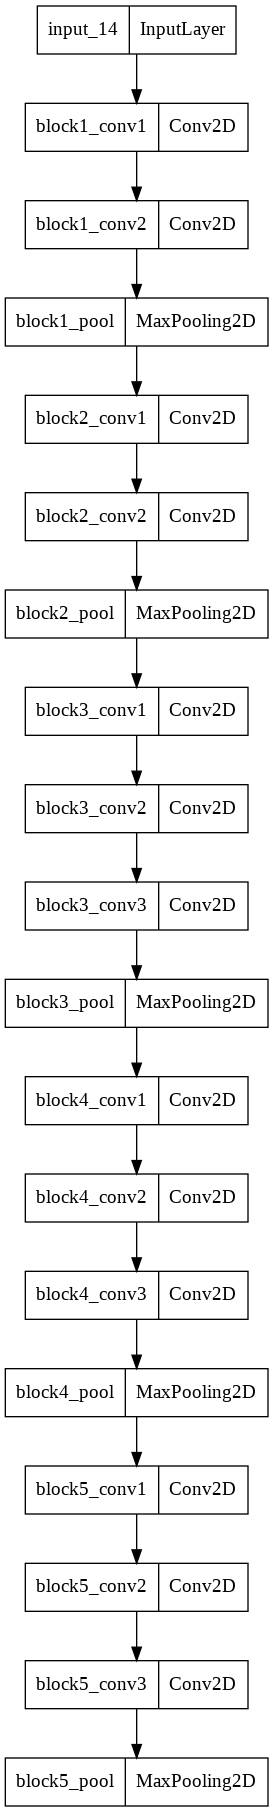

In [112]:
# VGG16 학습모델을 신경곱(CNN)층까지 전이학습

from keras.applications.vgg16 import VGG16

transfer_model = VGG16(input_shape = (224,224,3), weights = 'imagenet', include_top =False)

# transfer_model의 기존 가중치 고정
for layer in transfer_model.layers:
  layer.trainable = False

tf.keras.utils.plot_model(transfer_model)

In [113]:
def build_trainsfer_VGG16_classifier() :
                # VGG16 합성곱 층을 전이학습                     
          model = tf.keras.Sequential([transfer_model,
                                       
                # Classifier 출력층                      
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(64, activation = 'relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(4, activation = 'softmax')
])
          
          return model

vgg16_interior_model = build_trainsfer_VGG16_classifier()
vgg16_interior_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 25088)             0         
                                                                 
 dense_22 (Dense)            (None, 64)                1605696   
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 4)                 260       
                                                                 
Total params: 16,320,644
Trainable params: 1,605,956
Non-trainable params: 14,714,688
_________________________________________________________________


In [114]:
# 모델 컴파일
vgg16_interior_model.compile(optimizer = 'adam',
              loss ='sparse_categorical_crossentropy',
              metrics = 'accuracy')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best-cnn-interior-model.h5', 
                                                   save_best_only = True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 7, 
                                                     restore_best_weights= True)

# 모델 훈련
history = vgg16_interior_model.fit(train_gen, validation_data = valid_gen, epochs = 40,
                    callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/40
48/48 [==============================] - 15s 290ms/step - loss: 1.6069 - accuracy: 0.3333 - val_loss: 1.2442 - val_accuracy: 0.3917
Epoch 2/40
48/48 [==============================] - 14s 286ms/step - loss: 1.2021 - accuracy: 0.3896 - val_loss: 1.0139 - val_accuracy: 0.5833
Epoch 3/40
48/48 [==============================] - 14s 286ms/step - loss: 1.1063 - accuracy: 0.4812 - val_loss: 0.9202 - val_accuracy: 0.5750
Epoch 4/40
48/48 [==============================] - 14s 290ms/step - loss: 0.9451 - accuracy: 0.5583 - val_loss: 0.8998 - val_accuracy: 0.6083
Epoch 5/40
48/48 [==============================] - 15s 310ms/step - loss: 0.8872 - accuracy: 0.5646 - val_loss: 0.8352 - val_accuracy: 0.7083
Epoch 6/40
48/48 [==============================] - 13s 274ms/step - loss: 0.7844 - accuracy: 0.6229 - val_loss: 0.6922 - val_accuracy: 0.7500
Epoch 7/40
48/48 [==============================] - 13s 272ms/step - loss: 0.7472 - accuracy: 0.6521 - val_loss: 0.6958 - val_accuracy: 0.7417

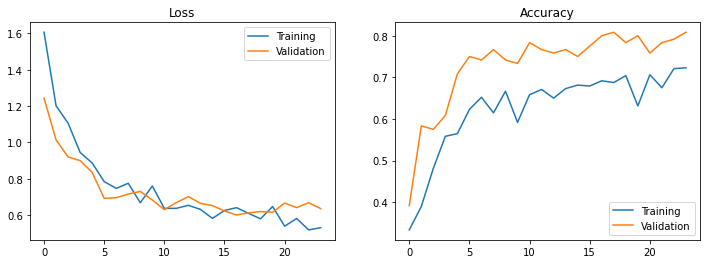

In [115]:
# 손실함수, 정확도 그래프 그리기
def plot_loss_acc(history):
  fig, axes =  plt.subplots(1,2, figsize = (12,4))
  axes[0].plot( history.history['loss'])
  axes[0].plot(history.history['val_loss'])
  axes[0].legend(labels = ['Training', 'Validation'])
  axes[0].set_title('Loss')
  
  axes[1].plot(history.history['accuracy'])
  axes[1].plot(history.history['val_accuracy'])
  axes[1].legend(labels = ['Training', 'Validation'])
  axes[1].set_title('Accuracy')

plot_loss_acc(history)

In [122]:
vgg16_interior_model.evaluate(valid_gen)

12/12 [==============================] - 3s 252ms/step - loss: 0.6008 - accuracy: 0.8000


[0.6007751226425171, 0.800000011920929]

In [123]:
# 예측

class_labels = ['Casual Style','Classic Style','Modern Style','Natural Style']

batch = next(valid_gen)
print(batch[1])
images, labels = batch[0], batch[1]
print(labels)

predictions = vgg16_interior_model.predict(batch[0])

[0. 3. 1. 1. 0. 3. 0. 0. 1. 3.]
[0. 3. 1. 1. 0. 3. 0. 0. 1. 3.]


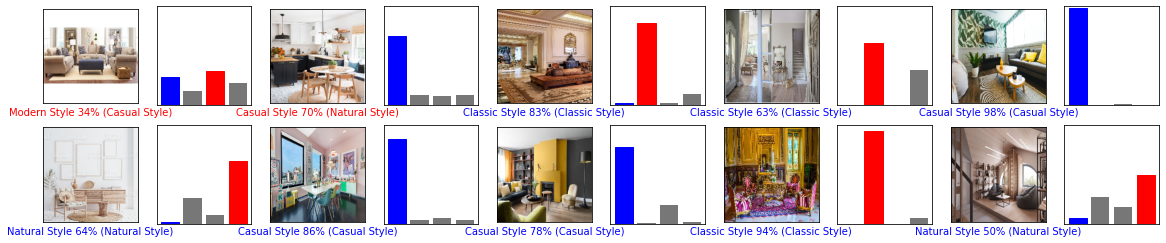

In [124]:
def plot_image(i, predictions_array, true_label, img): #순서, 예측확률
  predictions_array, img = predictions_array[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
 
  plt.imshow(img, cmap=plt.cm.binary)
 
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
 
  plt.xlabel("{} {:2.0f}% ({})".format(class_labels[predicted_label],
                                100*np.max(predictions_array),
                                class_labels[int(true_label)]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[np.argmax(true_label)].set_color('blue')

  
num_rows = 2
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))


for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, labels[i], images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions,labels)
plt.show()